In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Custom Top-K Layer
class TopK(Layer):
    def __init__(self, k, **kwargs):
        super(TopK, self).__init__(**kwargs)
        self.k = k

    def call(self, inputs):
        # Get top k values and indices
        top_k_values, top_k_indices = tf.math.top_k(inputs, k=self.k)

        # Create mask using scatter_nd
        batch_size = tf.shape(inputs)[0]
        batch_indices = tf.tile(tf.expand_dims(tf.range(batch_size), axis=1), multiples=[1, self.k])
        full_indices = tf.stack([batch_indices, top_k_indices], axis=-1)
        full_indices = tf.reshape(full_indices, [-1, 2])

        updates = tf.ones(shape=[tf.size(top_k_values)], dtype=tf.float32)
        mask = tf.scatter_nd(full_indices, updates, tf.shape(inputs))

        return inputs * mask


    def get_config(self):
        config = super().get_config().copy()
        config.update({'k': self.k})
        return config


In [ ]:
# Load and preprocess data
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:

# Autoencoder architecture
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='linear')(encoded)  # Linear activation before Top-K
encoded = TopK(k=32)(encoded)  # Keep top 32/64 activations
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:

# Train the model
history = autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 2/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 3/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 4/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 5/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 6/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 7/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 8/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 9/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 10/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 11/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 12/300
235/235 ━━━━━━━━━━━━━━━━━━━━

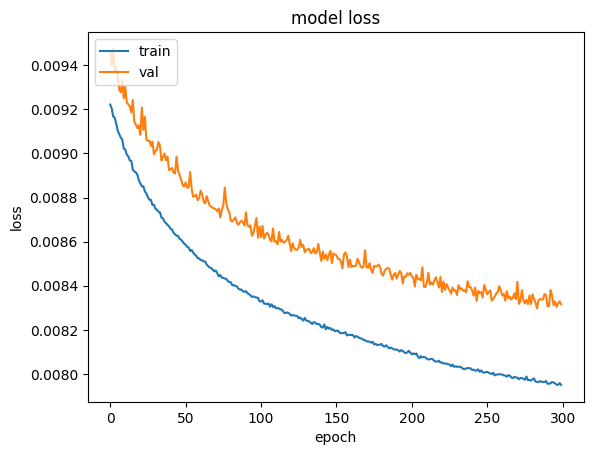

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss']) # Changed 'accuracy' to 'loss'
plt.plot(history.history['val_loss']) # Changed 'val_accuracy' to 'val_loss'
plt.title('model loss') # Changed title to reflect loss
plt.ylabel('loss') # Changed y-axis label to reflect loss
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


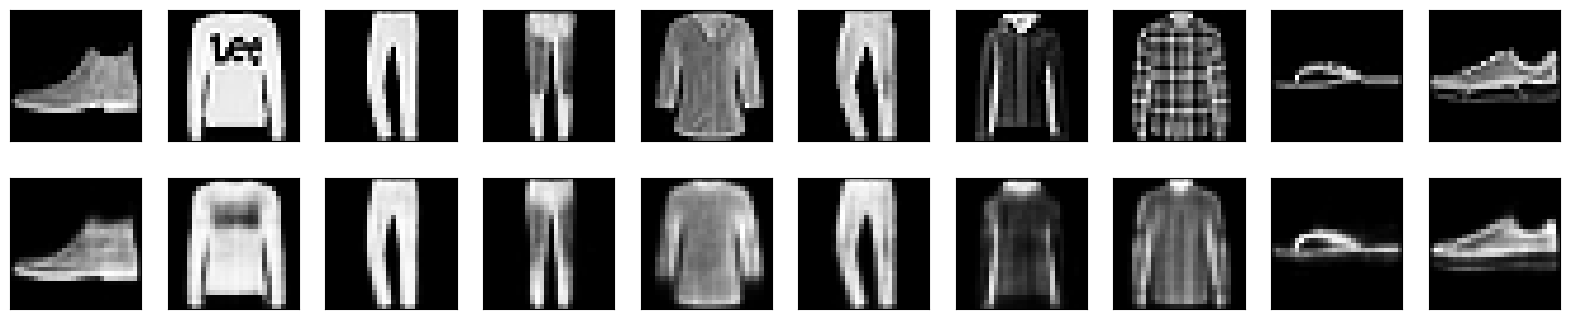

In [ ]:

# Visualization
decoded_imgs = autoencoder.predict(x_test)

n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()